# Graph Neural Networks Tutorial

### 1. Pytorch Geometric (PyG) Installation
- https://github.com/rusty1s/pytorch_geometric

### 2. Pytorch Geometric Framework
- Understanding Message Passing Scheme in Pytorch Geometric.
- Efficient graph data representations and paralleling minibatching graphs.

### 3. Node Classification/Regression Example
- Showcase of node classification on Cora dataset

### 3. Graph Classification/Regression Example
- Showcase of Graph regression on Lipo dataset from MoleculeNet

## 1. Pytorch Geometric (PyG) Installation

For the assignment purpose, you only need to install cpu-version of PyG. 
Please refer to the Github page https://github.com/rusty1s/pytorch_geometric and official documentations https://pytorch-geometric.readthedocs.io/en/latest/ for more details.

## 2. Pytorch Geometric Framework

#### Generic Message Passing Scheme
Generalizing the convolution operator to irregular domains is typically expressed as a *neighborhood aggregation* or *message passing* scheme.
With $\mathbf{x}^{(k-1)}_i \in \mathbb{R}^F$ denoting node features of node $i$ in layer $(k-1)$ and $\mathbf{e}_{i,j} \in \mathbb{R}^D$ denoting (optional) edge features from node $i$ to node $j$, message passing graph neural networks can be described as

$$
  \mathbf{x}_i^{(k)} = \gamma^{(k)} \left( \mathbf{x}_i^{(k-1)}, \psi_{j \in \mathcal{N}(i)} \, \phi^{(k)}\left(\mathbf{x}_i^{(k-1)}, \mathbf{x}_j^{(k-1)},\mathbf{e}_{i,j}\right) \right)
$$

where $\psi$ denotes a differentiable, permutation invariant function, *e.g.*, sum, mean or max, and $\gamma$ and $\phi$ denote differentiable functions such as MLPs (Multi Layer Perceptrons).

#### Graph data representations in PyG
Given a *sparse* **Graph** $\mathcal{G}=(\mathbf{X}, (\mathbf{I}, \mathbf{E}))$ with **node features** $\mathbf{X} \in \mathbb{R}^{|V| \times F}$, **edge indices $\mathbf{I} \in \{1, \cdots, N\}^{2 \times |\mathcal{E}|}$**, (optional) **edge features** $\mathbf{E} \in \mathbb{R}^{|\mathcal{E} \times D|}$, it is described by an instance of class `torch_geometric.data.Data`, which holds the corresponding attributes.

We show a simple example of an unweighted and directed graph with four nodes and three edges.

<!-- <p align="center"><img width="25%" src="figures/graph_data.png"></p> -->

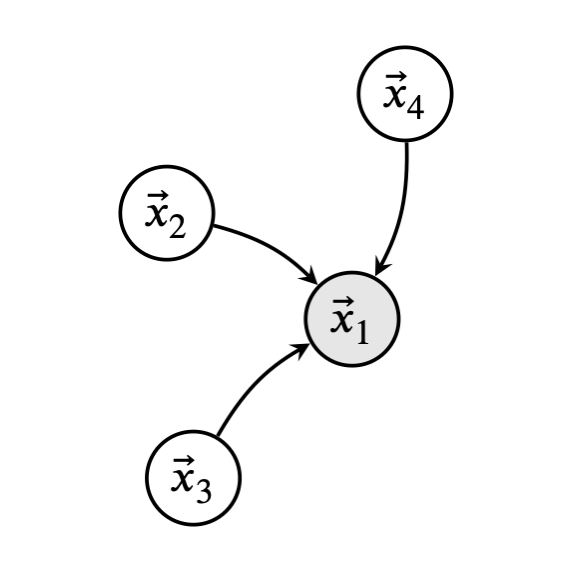

In [1]:
#INSTALLATION
!pip install rdkit-pypi -qqq

In [2]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[1, 2, 3], [0, 0, 0]], dtype=torch.long)
x = torch.tensor([[1], [1], [1], [1]], dtype=torch.float)

data = Data(edge_index=edge_index, x=x)
data

/home/cmu/anaconda3/envs/gnn-pyg/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data(x=[4, 1], edge_index=[2, 3])

#### Mini-Batching Graphs
Neural networks are usually trained in a batch-wise fashion. Minibatch graphs can be efficiently dealt with to achieve parallelization over a mini-batch from creating sparse block diagnoal adjacency matrices and concatenating features and target matrices in the node dimension.


<!-- <p align="center"><img width="70%" src="figures/mini_batch_graph.png"></p> -->
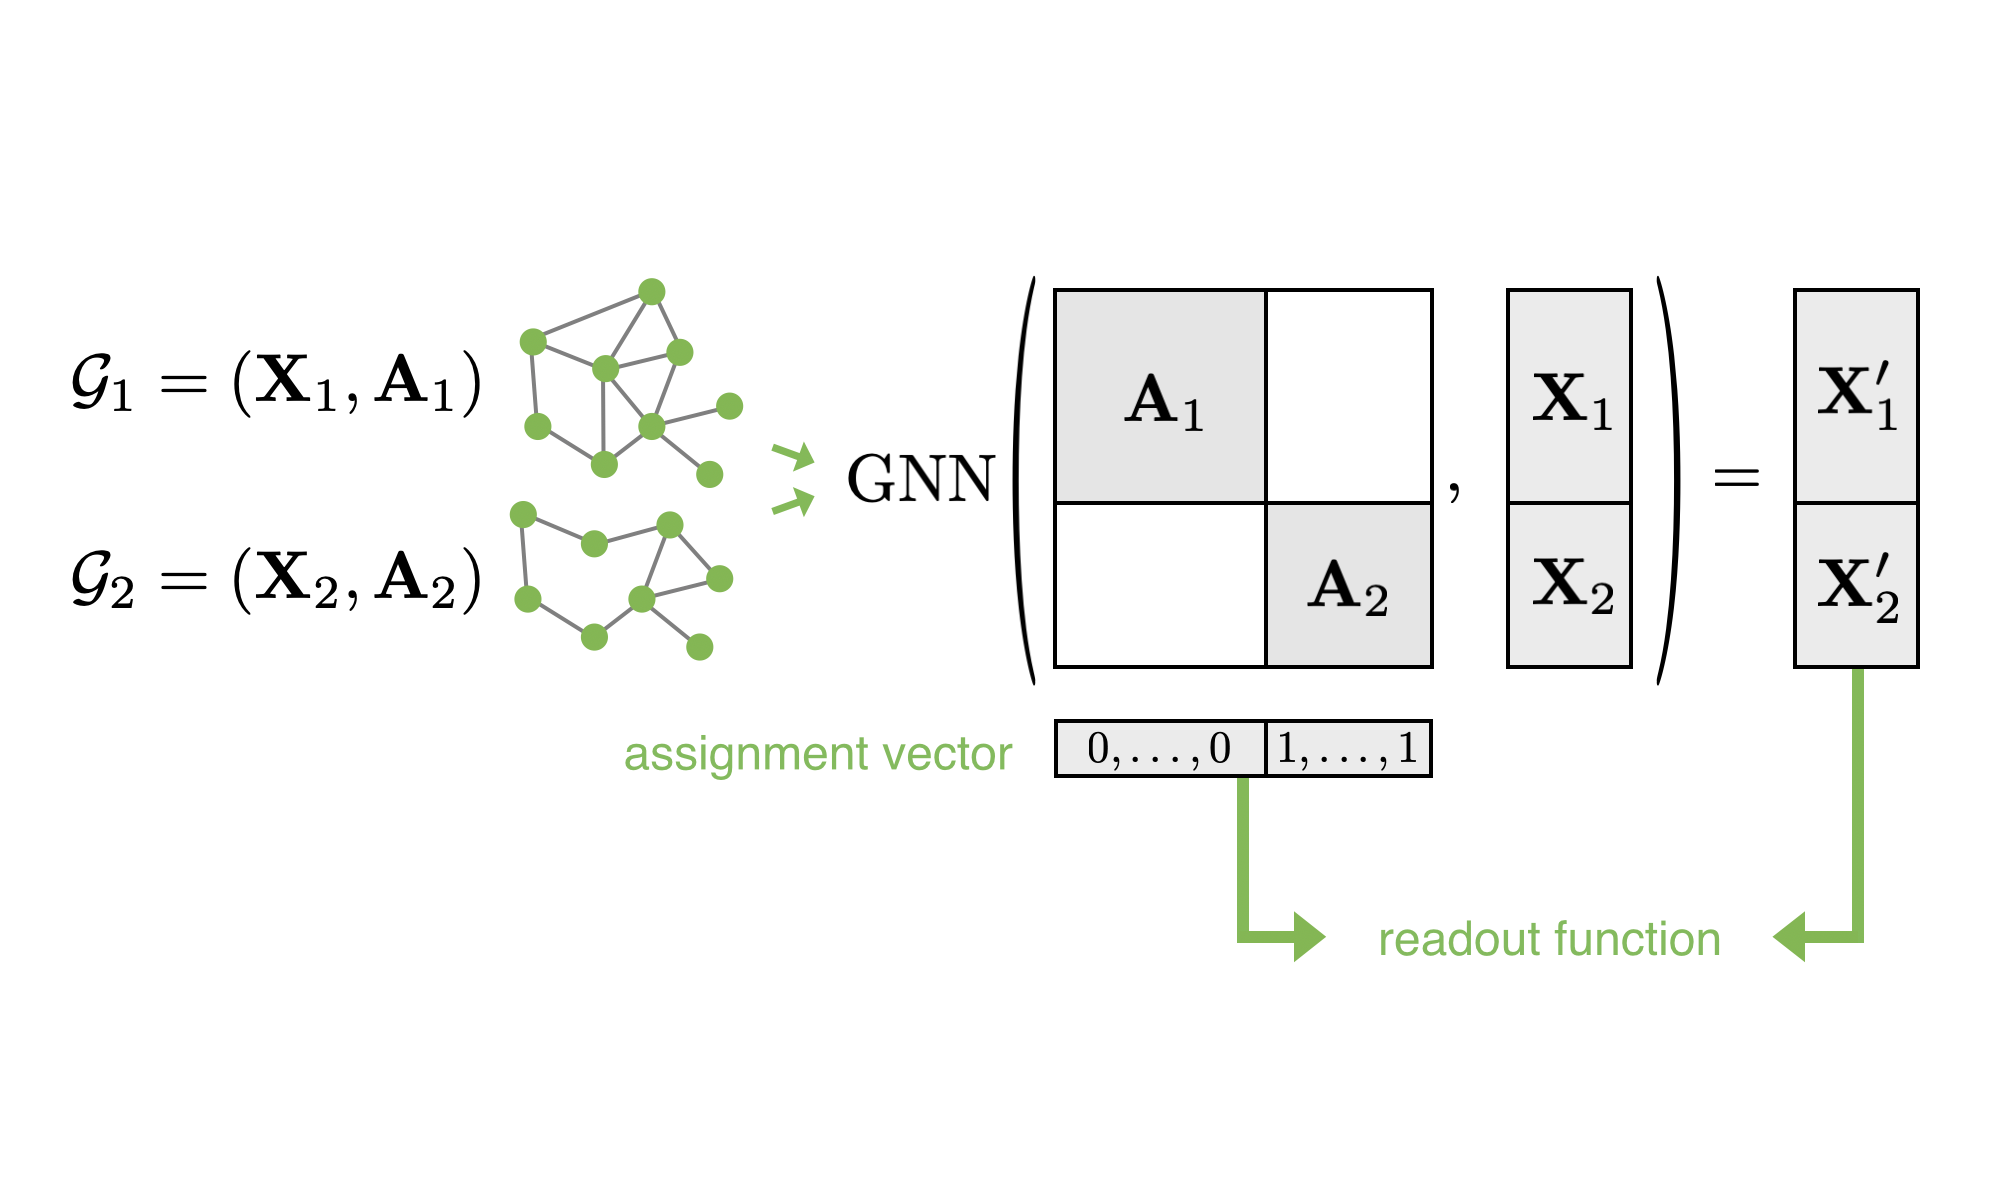

#### Abstract Message Passing Scheme in PyG

PyTorch Geometric provides the `torch_geometric.nn.MessagePassing` base class, which helps in creating such kinds of message passing graph neural networks by automatically taking care of message propagation. The implementation is decoupled into **UPDATE**, **AGGREGATION**, **MESSAGE** functions as:
$$
    \mathbf{x}_i^{(k)} = \mathrm{UPDATE} \left( \mathbf{x}_i, , \mathrm{AGGR}_{j \in \mathcal{N}(i)} \, \mathrm{MESSAGE}^{(k)}\left(\mathbf{x}_i^{(k-1)}, \mathbf{x}_j^{(k-1)},\mathbf{e}_{i,j}\right) \right)    
$$

<!-- <p align="center"><img width="70%" src="figures/message_passing.png"></p> -->
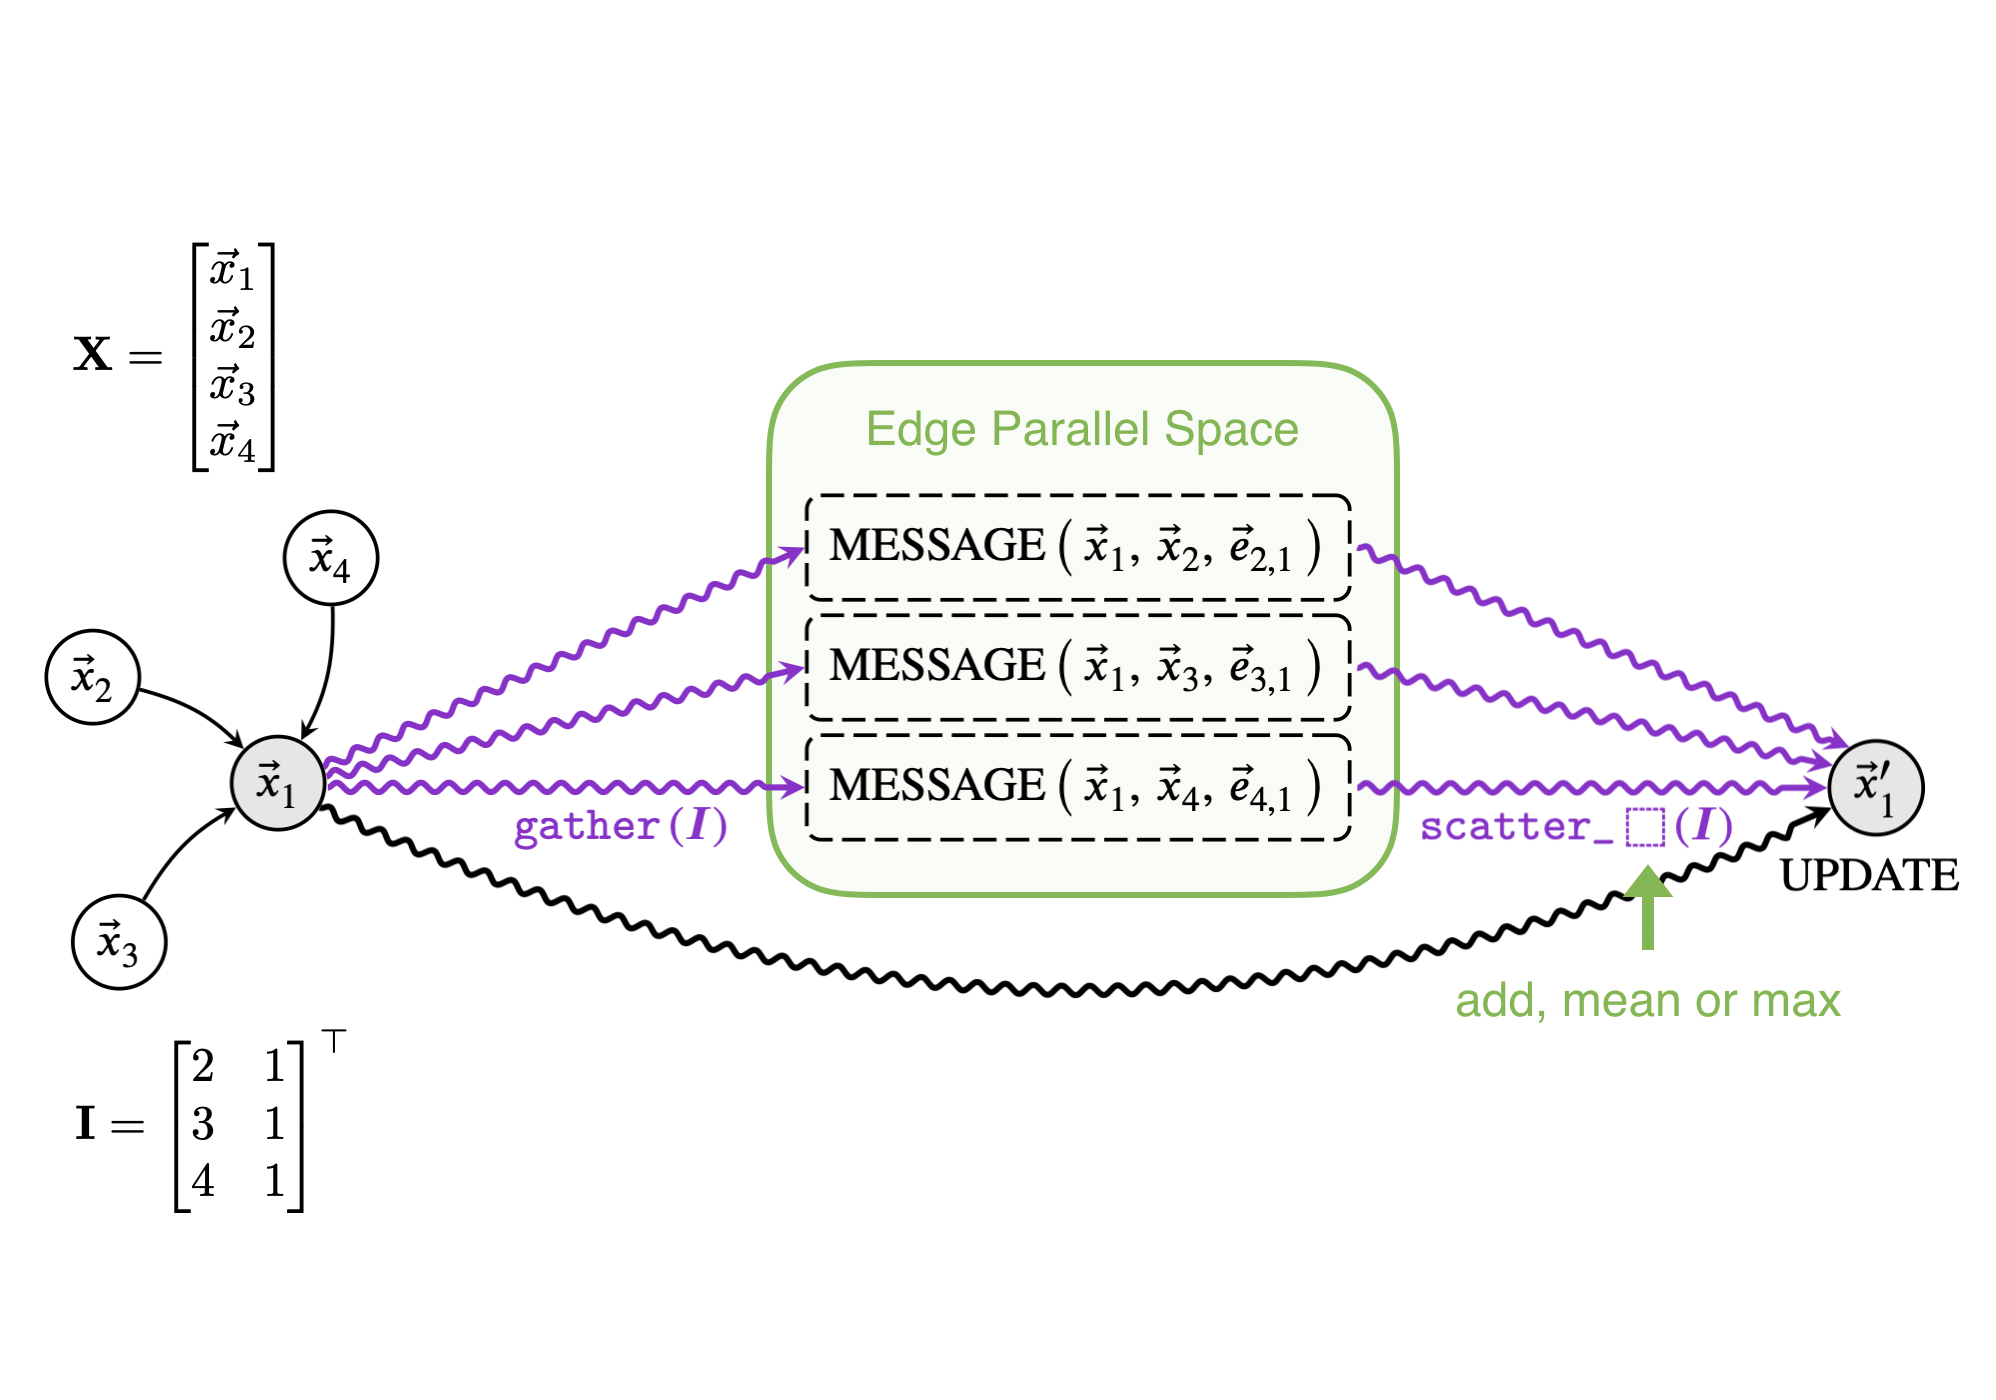

#### Implementing the GCN layer

The graph convolutional operator introduced by Kipf & Welling (ICLR 2017) is defined as
$$
        \mathbf{X}^{k} = \mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
        \mathbf{\hat{D}}^{-1/2} \mathbf{X}^{k-1} \mathbf{\Theta},
$$
where $\mathbf{\hat{A}} = \mathbf{A} + \mathbf{I}$ denotes the adjacency matrix with inserted self-loops and
$\hat{D}_{ii} = \sum_{j=0} \hat{A}_{ij}$ its diagonal degree matrix. It is equivalent as:
$$
\mathbf{x}_i^{(k)} = \sum_{j \in \mathcal{N}(i) \cup \{ i \}} \frac{1}{\sqrt{\deg(i)} \cdot \sqrt{deg(j)}} \cdot \left( \mathbf{x}_j^{(k-1)}\mathbf{\Theta} \right),
$$

where neighboring node features are first transformed by a weight matrix $\mathbf{\Theta}$, normalized by their degree, and finally summed up.
This formula can be divided into the following steps:

1. Add self-loops to the adjacency matrix.
2. Linearly transform node feature matrix.
3. Normalize node features.
4. Sum up neighboring node features.
5. Return new node embeddings.

## 3. Node Classification

In [3]:
import os
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, ChebConv  # noqa

# The Cora dataset consists of 2708 scientific publications classified into one of seven classes. 
# The citation network consists of 5429 links. 
# Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. 
# The dictionary consists of 1433 unique words.
dataset = 'Cora' 
dataset = Planetoid('.', dataset, transform=T.NormalizeFeatures())
data = dataset[0]
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Processing...
Done!


In [4]:
dataset.num_features,dataset.num_classes

(1433, 7)

In [5]:
class Net(nn.Module):
    def __init__(self, num_features, num_classes):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_features, 64, cached=True,
                             normalize=True)
        self.conv2 = GCNConv(64, 64, cached=True,
                             normalize=True)
        self.out_layer = nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_weight))
        x = F.dropout(x, training=self.training)
        return self.out_layer(x)

In [6]:
model = Net(dataset.num_features, dataset.num_classes)
optimizer = torch.optim.Adam([
    dict(params=model.conv1.parameters(), weight_decay=5e-4),
    dict(params=model.conv2.parameters(), weight_decay=0)
], lr=0.01)  # Only perform weight-decay on first convolution.


def train():
    model.train()
    optimizer.zero_grad()
    
    pred = model(data)[data.train_mask]
    label = data.y[data.train_mask]
    
    F.cross_entropy(pred, label).backward()
    optimizer.step()


@torch.no_grad()
def test():
    model.eval()
    logits, accs = model(data), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs


best_val_acc = test_acc = 0
for epoch in range(1, 201):
    train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, train_acc, best_val_acc, test_acc))


Epoch: 001, Train: 0.1429, Val: 0.1140, Test: 0.1040
Epoch: 002, Train: 0.1571, Val: 0.1140, Test: 0.1040
Epoch: 003, Train: 0.1786, Val: 0.1160, Test: 0.1100
Epoch: 004, Train: 0.2786, Val: 0.1420, Test: 0.1370
Epoch: 005, Train: 0.2500, Val: 0.1420, Test: 0.1370
Epoch: 006, Train: 0.2714, Val: 0.1420, Test: 0.1370
Epoch: 007, Train: 0.3643, Val: 0.1460, Test: 0.1410
Epoch: 008, Train: 0.4571, Val: 0.2280, Test: 0.2330
Epoch: 009, Train: 0.5857, Val: 0.3600, Test: 0.3800
Epoch: 010, Train: 0.6571, Val: 0.4900, Test: 0.5210
Epoch: 011, Train: 0.7357, Val: 0.5760, Test: 0.5940
Epoch: 012, Train: 0.7500, Val: 0.6260, Test: 0.6330
Epoch: 013, Train: 0.7500, Val: 0.6420, Test: 0.6470
Epoch: 014, Train: 0.7857, Val: 0.6460, Test: 0.6620
Epoch: 015, Train: 0.7857, Val: 0.6500, Test: 0.6650
Epoch: 016, Train: 0.8000, Val: 0.6580, Test: 0.6650
Epoch: 017, Train: 0.8071, Val: 0.6680, Test: 0.6710
Epoch: 018, Train: 0.8429, Val: 0.6840, Test: 0.6850
Epoch: 019, Train: 0.8714, Val: 0.7080, Test: 

## 4. Graph Regression

In [7]:
import os
import torch 
from torch import nn
import torch.nn.functional as F
from torch_geometric.datasets import QM7b, MoleculeNet
from torch_geometric.data import DataLoader
import torch_geometric.transforms as T
from torch_geometric.nn import GINEConv

# Lipophilicity: 4200 Experimental results of octanol/water distribution coefficient(logD at pH 7.4).
dataset = MoleculeNet('.', name='Lipo')
print(len(dataset))

# Normalize targets to mean = 0 and std = 1.
mean = dataset.data.y.mean(dim=0, keepdim=True)
std = dataset.data.y.std(dim=0, keepdim=True)
dataset.data.y = (dataset.data.y - mean) / std
mean, std = mean[:, 0].item(), std[:, 0].item()
print(mean, std)

# Split datasets.
test_dataset = dataset[:int(len(dataset)*0.2)]
train_dataset = dataset[int(len(dataset)*0.2):]
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

Processing...


4200
2.186335563659668 1.2030037641525269


Done!
/home/cmu/anaconda3/envs/gnn-pyg/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [8]:
from torch_geometric.nn import global_max_pool

class Net(nn.Module):
    def __init__(self, num_features, num_classes):
        super(Net, self).__init__()
        self.embed = nn.Linear(num_features, 64)
        self.conv1 = GCNConv(64, 64, normalize=True)
        self.conv2 = GCNConv(64, 64, normalize=True)
        self.conv3 = GCNConv(64, 64, normalize=True)
        self.out_layer = nn.Linear(64, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.embed(x.type(torch.FloatTensor))
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv3(x, edge_index))
        x = F.dropout(x, training=self.training)
        
        x = global_max_pool(x, data.batch)
        
        return self.out_layer(x)

In [9]:
for data in train_loader:
    print(data)
    print(data.edge_attr)
    break

DataBatch(x=[1753, 9], edge_index=[2, 3816], edge_attr=[3816, 3], smiles=[64], y=[64, 1], batch=[1753], ptr=[65])
tensor([[ 1,  0,  0],
        [ 1,  0,  0],
        [12,  0,  1],
        ...,
        [ 1,  0,  0],
        [12,  0,  1],
        [12,  0,  1]])


In [11]:
model = Net(dataset.num_features, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

def train():
    model.train()
    mse_error = 0.0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        pred = model(data)
        label = data.y[:,0]

        loss = F.mse_loss(pred.squeeze(), label)
        loss.backward()
        
        optimizer.step()
        
        mse_error += loss.item()
    return mse_error / (i+1)

@torch.no_grad()
def test():
    model.eval()
    mse_error = 0.0
    for i, data in enumerate(test_loader):
        optimizer.zero_grad()

        pred = model(data)
        label = data.y[:,0]

        mse_error += F.mse_loss(pred.squeeze(), label).item()
        optimizer.step()
    return mse_error / (i+1)

test_error = test()
log = 'Epoch: {:03d}, Train: {:.4f}, Test: {:.4f}'
print(log.format(0, np.inf, test_error))

for epoch in range(1, 51):
    train_error = train()
    test_error = test()
    log = 'Epoch: {:03d}, Train: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, train_error, test_error))

Epoch: 000, Train: inf, Test: 1.1464
Epoch: 001, Train: 1.3033, Test: 1.0890
Epoch: 002, Train: 1.1913, Test: 0.9815
Epoch: 003, Train: 1.1606, Test: 0.9526
Epoch: 004, Train: 1.1330, Test: 0.9395
Epoch: 005, Train: 1.0863, Test: 0.9337
Epoch: 006, Train: 1.0661, Test: 0.9301
Epoch: 007, Train: 1.0537, Test: 0.9326
Epoch: 008, Train: 1.0374, Test: 0.9294
Epoch: 009, Train: 1.0265, Test: 0.9278
Epoch: 010, Train: 1.0312, Test: 0.9272
Epoch: 011, Train: 1.0228, Test: 0.9274
Epoch: 012, Train: 1.0197, Test: 0.9289
Epoch: 013, Train: 1.0234, Test: 0.9321
Epoch: 014, Train: 1.0132, Test: 0.9286
Epoch: 015, Train: 1.0138, Test: 0.9229
Epoch: 016, Train: 1.0102, Test: 0.9307
Epoch: 017, Train: 1.0070, Test: 0.9244
Epoch: 018, Train: 1.0088, Test: 0.9237
Epoch: 019, Train: 0.9982, Test: 0.9218
Epoch: 020, Train: 0.9972, Test: 0.9209
Epoch: 021, Train: 1.0005, Test: 0.9222
Epoch: 022, Train: 0.9860, Test: 0.9202
Epoch: 023, Train: 0.9738, Test: 0.9192
Epoch: 024, Train: 0.9939, Test: 0.9190
Epo